# Turnover des collaborateurs à l'AN

## Introduction

Cet étude est basée sur les listes de collaborateurs par députés [publiées par l'Assemblée Nationale](http://www2.assemblee-nationale.fr/qui/liste-des-collaborateurs-par-depute), collectées et transformées par [Regards Citoyens](https://github.com/regardscitoyens/Collaborateurs-Parlement), puis concaténées et opérationnalisées par nos soins.

Elle cherche à quantifier la rotation de l'emploi, ou _turnover_, des collaborateurs en analysant la durée de leurs contrats de travail, ainsi que les caractéristiques des parlementaires qui les emploient.

Nous employons des méthodes issues de la statistique descriptive et inférentielle pour comprendre s'il existe des profils de collaborations entre les parlementaires et les assistants qu'ils emploient.

## Préparation des données

In [286]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# Fichier généré quotidiennenement par nosdeputes.fr depuis le site de l'AN
csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["groupe_majoritaire"] = (csv["groupe_sigle"] == "LREM") | (csv["groupe_sigle"] == "MODEM")

# Parsing des dates de contrat, de mandat et de naissance
csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])

# Calcul des temps de contrat, de mandat et de l'âge
csv["contrat_fini"] = (csv["mandat_fin"] - csv["sortie"]).astype(int) > 10000000000000
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

# Calcul du nombre de contrats courts par parlementaire
csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1

#Preparation indicateur Rotation de l'emploi
#https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi
date_rotation_un_an = "2017-10-01"
csv["contrat_present_a_date_rotation_un_an"] = (csv["entree"] <= date_rotation_un_an) & (csv["sortie"] > date_rotation_un_an)
csv["contrat_entree_depuis_date_rotation_un_an"] = (csv["entree"] > date_rotation_un_an)
csv["contrat_sortie_depuis_date_rotation_un_an"] = (csv["sortie"] > date_rotation_un_an) & (csv["sortie"] < max(csv["sortie"]))
date_rotation_six_mois = "2018-04-01"
csv["contrat_present_a_date_rotation_six_mois"] = (csv["entree"] <= date_rotation_six_mois) & (csv["sortie"] > date_rotation_six_mois)
csv["contrat_entree_depuis_date_rotation_six_mois"] = (csv["entree"] > date_rotation_six_mois)
csv["contrat_sortie_depuis_date_rotation_six_mois"] = (csv["sortie"] > date_rotation_six_mois) & (csv["sortie"] < max(csv["sortie"]))

csv["contrat_present_a_date_rotation_six_premiers_mois"] = csv["contrat_present_a_date_rotation_un_an"]
csv["contrat_entree_depuis_date_rotation_six_premiers_mois"] = (csv["entree"] > date_rotation_un_an) & (csv["entree"] < date_rotation_six_mois)
csv["contrat_sortie_depuis_date_rotation_six_premiers_mois"] = (csv["sortie"] > date_rotation_un_an) & (csv["sortie"] < date_rotation_six_mois)


# Suppression des contrat inférieur à 7 jours (problème liés aux ministres)
csv = csv[csv["nombredejours"] > 7]

# Suppression des contrats courts de début de législature (fin de contrat de la législature précédente)
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]
# Supression des députés plus en mandat
csv = csv[csv["mandat_fin"] == max(csv["mandat_fin"])]
csv = csv[csv["mandat_debut"] < date_rotation_un_an]

# Suppression des colonnes inutiles du fichiers d'entrée
csv.drop("collaborateurs", 1, inplace=True)

### Contrôle

In [228]:
csv.head()

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,parlementaire_age,contrat_plus_de_2_mois,contrat_plus_de_4_mois,contrat_plus_de_6_mois,contrat_present_a_date_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_a_date_rotation_six_mois,contrat_entree_depuis_date_rotation_six_mois,contrat_sortie_depuis_date_rotation_six_mois
0,Louis Aliot,Aliot,Louis,H,Mme Rania Messiha,Messiha,Rania,F,https://www.nosdeputes.fr/louis-aliot/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,49,1,1,1,True,False,False,True,False,False
1,Bertrand Bouyx,Bouyx,Bertrand,H,M. Hugo Guillochin,Guillochin,Hugo,H,https://www.nosdeputes.fr/bertrand-bouyx/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,48,1,1,1,True,False,False,True,False,False
2,Stéphane Buchou,Buchou,Stéphane,H,Mme Claire Legrand,Legrand,Claire,F,https://www.nosdeputes.fr/stephane-buchou/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,44,1,1,1,True,False,False,True,False,False
3,Cédric Roussel,Roussel,Cédric,H,Mme Caroline Puisségur-Ripet,Puisségur-Ripet,Caroline,F,https://www.nosdeputes.fr/cedric-roussel/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,45,1,1,1,False,True,False,True,False,False
4,Isabelle Valentin,Valentin,Isabelle,F,Mme Céline Saby,Saby,Céline,F,https://www.nosdeputes.fr/isabelle-valentin/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,56,1,1,1,True,False,False,True,False,False


### Nombre de collaborateurs depuis le début de la législature

In [281]:
len(csv['collaborateur'].unique())

2726

Nombre de collaborateurs en cours de contrat :

In [282]:
((csv['contrat_fini']  != True) * 1).sum()

1991

Durée moyenne d'un contrat :

In [315]:
csv["nombredejours"].mean()/30.5

8.850770956303036

### Rotation de l'emploi au niveau global

La rotation de l'emploi, ou renouvellement du personnel, est [définie comme suit](https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi) : ((recrutements + fins de contrats) / 2) / nombre d'emplois en début de période.

Celle de l'ensemble des collaborateurs de l'Assemblée sur l'année est de 64%. D'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf), ce taux est sensiblement identique au taux national français pour des emplois du tertiaires.

In [289]:
(((csv["contrat_entree_depuis_date_rotation_un_an"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_un_an"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_un_an"]*1).sum())

0.6406641604010025

A quel point ce taux de rotation est lié à des "erreurs de casting" en début de législature ?

Comparons le taux de rotation sur les six derniers mois :

In [290]:
(((csv["contrat_entree_depuis_date_rotation_six_mois"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_six_mois"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_six_mois"]*1).sum())

0.22105532786885246

sur les six premiers mois :

In [291]:
(((csv["contrat_entree_depuis_date_rotation_six_premiers_mois"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_six_premiers_mois"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_six_premiers_mois"]*1).sum())

0.37030075187969924

## Temporalité des fins de contrats

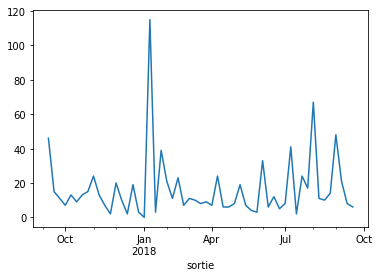

In [292]:
csv.index = csv["sortie"]
csv[csv.index != max(csv["sortie"])].resample('W').count()["nom_parlementaire"].plot()

In [293]:
csv[csv.index != max(csv["sortie"])].resample('D').count()["nom_parlementaire"].sort_values(ascending=False).head(20)

sortie
2018-01-09    105
2017-09-05     40
2018-09-02     39
2018-08-02     35
2018-01-26     33
2018-07-02     29
2018-06-02     20
2018-07-20     19
2018-02-17     18
2018-04-02     17
2018-02-02     15
2018-08-05     13
2017-11-02     12
2018-05-02     11
2017-12-02     11
2017-12-23      8
2018-03-02      8
2017-10-21      8
2018-08-03      8
2018-08-26      7
Name: nom_parlementaire, dtype: int64

Le ratio des départs des collaborateurs provenant d'un groupe majoritaire par rapport à l'ensemble des départ laisse entendre que ces évènements sont-il liés à l'appartenance à un groupe majoritaire.

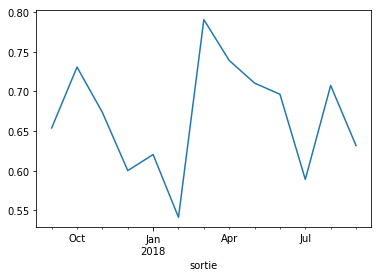

In [295]:
(csv[(csv.index != max(csv["sortie"])) & (csv['groupe_majoritaire'])].resample('M').count()["nom_parlementaire"] / csv[csv.index != max(csv["sortie"])].resample('M').count()["nom_parlementaire"]).plot()


## Durée des contrats

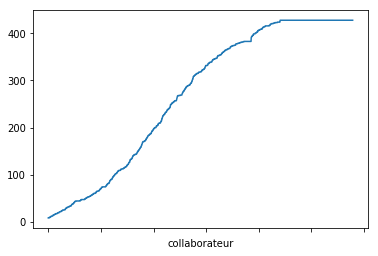

In [296]:
contrats = csv[["nombredejours", "collaborateur"]].reset_index()[["nombredejours", "collaborateur"]]
contrats.index = contrats["collaborateur"]
contrats["nombredejours"].sort_values().plot()

Les deux plateaux inférieurs à 100 jours sont-ils liés à des effets saisonniers (pic de janvier 2018) ou à des contrats d'opportunité/carrière ?

## Description générale du comportement des députés

### Préparation des données

In [307]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nom_circo']].first().rename(columns={"nom_circo": "departement"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs_total"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs_total']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs_total']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs_total']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs_total']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")

#Rotation emploi
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_un_an', 'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an']].sum().reset_index(), on="parlementaire")
duree_collaborateurs['contrat_present_moyen'] = (duree_collaborateurs['contrat_present_a_date_rotation_un_an'] + duree_collaborateurs['nb_collaborateurs_total'] - duree_collaborateurs['nb_contrat_fini']) / 2
duree_collaborateurs["emploi_rotation_un_an"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_un_an']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_un_an'])/2)/duree_collaborateurs['contrat_present_moyen']
duree_collaborateurs["emploi_taux_depart_un_an"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_un_an']/duree_collaborateurs['contrat_present_moyen']
duree_collaborateurs["emploi_taux_arrivee_un_an"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_un_an']/duree_collaborateurs['contrat_present_moyen']

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_six_mois', 'contrat_entree_depuis_date_rotation_six_mois', 'contrat_sortie_depuis_date_rotation_six_mois']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation_six_mois"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_six_mois']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_mois'])/2)/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']
duree_collaborateurs["emploi_taux_depart_six_mois"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']
duree_collaborateurs["emploi_taux_arrivee_six_mois"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_six_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_six_premiers_mois', 'contrat_entree_depuis_date_rotation_six_premiers_mois', 'contrat_sortie_depuis_date_rotation_six_premiers_mois']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation_six_premiers_mois"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_six_premiers_mois']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_premiers_mois'])/2)/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']
duree_collaborateurs["emploi_taux_depart_six_premiers_mois"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_premiers_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']
duree_collaborateurs["emploi_taux_arrivee_six_premiers_mois"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_six_premiers_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']


duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

### Durée des contrats de collaborateurs

Certains députés ont des collaborateurs fidèles. Le graphique suivant représente le contrat le plus long de chacun des parlementaires. Les _fidèles_ sont représentés par le palier supérieur à droite : la durée de leur contrat est égale à la durée de la législature.

On observe un second palier plus réduit à 300 jours, il représente probablement les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

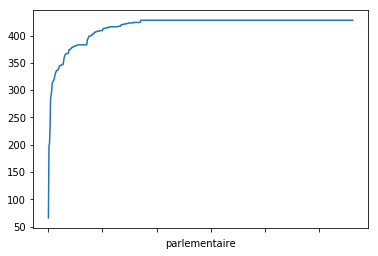

In [298]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Le graphique infra représente le contrat le plus court pour chacun des parlementaires.

Certains parlementaires n'ont aucun contrat court, ils n'ont que des collaborateurs fidèles en contrat de longue durée. D'autres se sont parfois séparé d'un collaborateur après moins de 20 jours.

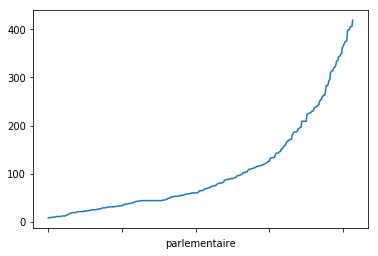

In [299]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Près de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois : la période d'essai d'un CDI de collaborateur est de 2 mois.

In [300]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 122]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

52.4822695035461

### Rotation de l'emploi

La rotation de l'emploi moyenne des collaborateurs d'un député est de 60%. Au niveau national, elle est de 58,8% dans les établissements de 1 à 9 salariés d'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf).

La répartition par quartile et la visualisation de la distribution montrent en revanche que 25% des députés ont une rotation d'emploi nettemment au dessus de la moyenne nationale.

In [303]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] < 100]["emploi_rotation_un_an"].describe()

count    564.000000
mean       0.604922
std        0.519588
min        0.000000
25%        0.200000
50%        0.500000
75%        1.000000
max        3.000000
Name: emploi_rotation_un_an, dtype: float64

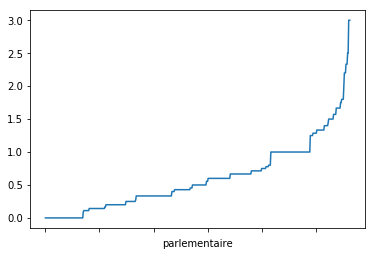

In [304]:
duree_collaborateurs.sort_values("emploi_rotation_un_an").set_index("parlementaire")["emploi_rotation_un_an"].plot()
#duree_collaborateurs["emploi_rotation"].plot()

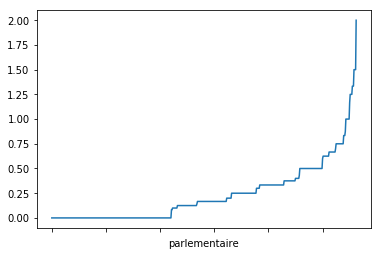

In [305]:
duree_collaborateurs.sort_values("emploi_rotation_six_mois").set_index("parlementaire")["emploi_rotation_six_mois"].plot()


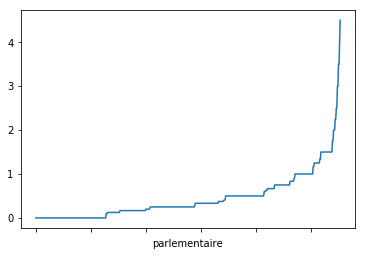

In [308]:
duree_collaborateurs.sort_values("emploi_rotation_six_premiers_mois").set_index("parlementaire")["emploi_rotation_six_premiers_mois"].plot()


## Les députés et leurs collaborateurs

### Durées plus faibles du contrat le plus long

Le tri infra des parlementaires par la durée du contrat de collaborateur le plus long fait remonter ceux qui gardent peu de collaborateurs sur le long terme : leurs collaborateurs n'ont pas beaucoup d'ancienneté, **ils n'ont pas de fidèles**

In [309]:
# Suppression des députés nouvellement élus avant le tri
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('contrat_max').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "ratio_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs_total,contrat_max,nb_contrat_fini,ratio_contrat_fini,...,contrat_sortie_depuis_date_rotation_six_mois,emploi_rotation_six_mois,emploi_taux_depart_six_mois,emploi_taux_arrivee_six_mois,contrat_present_a_date_rotation_six_premiers_mois,contrat_entree_depuis_date_rotation_six_premiers_mois,contrat_sortie_depuis_date_rotation_six_premiers_mois,emploi_rotation_six_premiers_mois,emploi_taux_depart_six_premiers_mois,emploi_taux_arrivee_six_premiers_mois
323,Amélia Lakrafi,LREM,F,Français établis hors de France,66.0,62.800000,5,66.0,0.0,0.000000,...,0.0,inf,NaN,inf,0.0,0.0,0.0,NaN,NaN,NaN
44,Anissa Khedher,LREM,F,Rhône,162.5,136.333333,6,197.0,4.0,0.666667,...,1.0,1.500000,1.000000,2.000000,3.0,1.0,3.0,0.666667,1.0,0.333333
68,José Evrard,NI,H,Pas-de-Calais,123.5,122.625000,8,203.0,5.0,0.625000,...,2.0,0.375000,0.500000,0.250000,1.0,6.0,3.0,4.500000,3.0,6.000000
486,Loïc Dombreval,LREM,H,Alpes-Maritimes,189.0,176.400000,5,228.0,2.0,0.400000,...,0.0,0.250000,0.000000,0.500000,2.0,2.0,2.0,1.000000,1.0,1.000000
473,Marie Lebec,LREM,F,Yvelines,274.5,251.000000,4,284.0,1.0,0.250000,...,0.0,0.000000,0.000000,0.000000,1.0,3.0,1.0,2.000000,1.0,3.000000
94,Valérie Petit,LREM,F,Nord,102.0,133.555556,9,291.0,5.0,0.555556,...,1.0,0.500000,0.333333,0.666667,3.0,3.0,3.0,1.000000,1.0,1.000000
345,Sandra Marsaud,LREM,F,Charente,110.5,157.000000,6,298.0,3.0,0.500000,...,1.0,0.333333,0.333333,0.333333,2.0,3.0,2.0,1.250000,1.0,1.500000
13,Florence Lasserre-David,MODEM,F,Pyrénées-Atlantiques,144.0,147.200000,5,312.0,3.0,0.600000,...,1.0,1.500000,1.000000,2.000000,1.0,1.0,1.0,1.000000,1.0,1.000000
52,Aude Amadou,LREM,F,Loire-Atlantique,180.0,182.285714,7,315.0,5.0,0.714286,...,2.0,0.250000,0.500000,0.000000,2.0,4.0,2.0,1.500000,1.0,2.000000
54,Laëtitia Romeiro Dias,LREM,F,Essonne,108.0,151.142857,7,317.0,5.0,0.714286,...,2.0,1.000000,1.000000,1.000000,3.0,2.0,3.0,0.833333,1.0,0.666667


### Nombres de contrats de plus de 6 mois les plus faibles

Le tri croissant par le ratio de contrats de plus de 6 mois sur le nombre total de contrats fait remonter les députés ayant des fidèles mais cumulant de nombreux contrats de mois de 6 mois.

In [310]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_plus_de_6_mois').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs_total,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,...,contrat_sortie_depuis_date_rotation_six_mois,emploi_rotation_six_mois,emploi_taux_depart_six_mois,emploi_taux_arrivee_six_mois,contrat_present_a_date_rotation_six_premiers_mois,contrat_entree_depuis_date_rotation_six_premiers_mois,contrat_sortie_depuis_date_rotation_six_premiers_mois,emploi_rotation_six_premiers_mois,emploi_taux_depart_six_premiers_mois,emploi_taux_arrivee_six_premiers_mois
5,Danielle Brulebois,LREM,F,Jura,60.0,102.818182,11,381.0,0.272727,8.0,...,2.0,0.666667,0.666667,0.666667,3.0,3.0,3.0,1.000000,1.0,1.000000
44,Anissa Khedher,LREM,F,Rhône,162.5,136.333333,6,197.0,0.333333,4.0,...,1.0,1.500000,1.000000,2.000000,3.0,1.0,3.0,0.666667,1.0,0.333333
153,Thierry Solère,LREM,H,Hauts-de-Seine,141.5,181.333333,6,332.0,0.333333,4.0,...,0.0,0.000000,0.000000,0.000000,2.0,3.0,3.0,1.500000,1.5,1.500000
68,José Evrard,NI,H,Pas-de-Calais,123.5,122.625000,8,203.0,0.375000,5.0,...,2.0,0.375000,0.500000,0.250000,1.0,6.0,3.0,4.500000,3.0,6.000000
30,Laurence Maillart-Méhaignerie,LREM,F,Ille-et-Vilaine,115.0,146.500000,8,428.0,0.375000,5.0,...,1.0,0.333333,0.333333,0.333333,2.0,5.0,4.0,2.250000,2.0,2.500000
4,Valérie Rabault,NG,F,Tarn-et-Garonne,76.0,138.875000,8,428.0,0.375000,5.0,...,3.0,1.000000,1.000000,1.000000,2.0,3.0,2.0,1.250000,1.0,1.500000
29,Jean-Marc Zulesi,LREM,H,Bouches-du-Rhône,114.5,143.125000,8,365.0,0.375000,5.0,...,2.0,0.666667,0.666667,0.666667,3.0,3.0,3.0,1.000000,1.0,1.000000
26,Danièle Hérin,LREM,F,Aude,99.0,172.875000,8,416.0,0.375000,6.0,...,2.0,0.500000,0.666667,0.333333,4.0,3.0,4.0,0.875000,1.0,0.750000
25,Pascale Boyer,LREM,F,Hautes-Alpes,91.0,152.625000,8,416.0,0.375000,5.0,...,2.0,1.250000,1.000000,1.500000,2.0,3.0,3.0,1.500000,1.5,1.500000
17,M'jid El Guerrab,NI,H,Français établis hors de France,101.0,197.000000,5,428.0,0.400000,3.0,...,1.0,0.500000,0.500000,0.500000,2.0,2.0,2.0,1.000000,1.0,1.000000


### Le nombre de contrats terminés

Trier les parlementaires par la proportion de contrats clos parmis tous leurs contrats de collaborateur (contrats très courts et parlementaires nouvellement élus exclus) ou par le taux de départ permet d'isoler ceux s'étant souvent séparé de leur personnel.

In [316]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_contrat_fini', ascending=False).drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "contrat_mediane", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs_total", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini", "emploi_rotation_un_an"]].head(15)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,ratio_contrat_fini,contrat_moyenne,nb_collaborateurs_total,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,emploi_rotation_un_an
211,Barbara Bessot Ballot,LREM,F,Haute-Saône,0.800000,203.400000,5,336.0,0.600000,4.0,2.333333
26,Danièle Hérin,LREM,F,Aude,0.750000,172.875000,8,416.0,0.375000,6.0,1.666667
70,Richard Ramos,MODEM,H,Loiret,0.750000,228.500000,4,359.0,0.750000,3.0,1.000000
27,Anne-France Brunet,LREM,F,Loire-Atlantique,0.750000,188.750000,8,428.0,0.500000,6.0,2.500000
134,Sira Sylla,LREM,F,Seine-Maritime,0.727273,134.000000,11,407.0,0.545455,8.0,1.750000
5,Danielle Brulebois,LREM,F,Jura,0.727273,102.818182,11,381.0,0.272727,8.0,1.666667
54,Laëtitia Romeiro Dias,LREM,F,Essonne,0.714286,151.142857,7,317.0,0.428571,5.0,1.800000
168,Xavier Paluszkiewicz,LREM,H,Meurthe-et-Moselle,0.714286,182.571429,7,428.0,0.428571,5.0,1.333333
52,Aude Amadou,LREM,F,Loire-Atlantique,0.714286,182.285714,7,315.0,0.428571,5.0,2.000000
153,Thierry Solère,LREM,H,Hauts-de-Seine,0.666667,181.333333,6,332.0,0.333333,4.0,1.500000


## Ratio d'emploi

Taux de départ sur un an le plus fort :

In [318]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] < 100].sort_values(['emploi_taux_depart_un_an', "emploi_rotation_un_an"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_taux_depart_un_an", "emploi_taux_depart_six_mois", "emploi_taux_depart_six_premiers_mois", "emploi_rotation_un_an",  "emploi_rotation_six_mois", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", 'contrat_present_a_date_rotation_un_an', 'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an', "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs_total", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini"]].head(50)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_taux_depart_un_an,emploi_taux_depart_six_mois,emploi_taux_depart_six_premiers_mois,emploi_rotation_un_an,emploi_rotation_six_mois,emploi_taux_depart_un_an,emploi_taux_arrivee_un_an,contrat_present_a_date_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,ratio_contrat_fini,contrat_moyenne,nb_collaborateurs_total,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini
211,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.666667,1.000000,1.000000,2.333333,0.750000,2.666667,2.000000,2.0,3.0,4.0,0.800000,203.400000,5,336.0,0.600000,4.0
68,José Evrard,NI,H,Pas-de-Calais,2.500000,0.500000,3.000000,3.000000,0.375000,2.500000,3.500000,1.0,7.0,5.0,0.625000,122.625000,8,203.0,0.375000,5.0
99,Sonia Krimi,LREM,F,Manche,2.500000,0.750000,2.000000,3.000000,0.625000,2.500000,3.500000,1.0,7.0,5.0,0.666667,142.777778,9,338.0,0.444444,6.0
27,Anne-France Brunet,LREM,F,Loire-Atlantique,2.500000,0.600000,1.000000,2.500000,0.300000,2.500000,2.500000,2.0,5.0,5.0,0.750000,188.750000,8,428.0,0.500000,6.0
341,Aude Bono-Vandorme,LREM,F,Aisne,2.500000,1.000000,0.000000,1.500000,0.500000,2.500000,0.500000,4.0,1.0,5.0,1.000000,347.200000,5,362.0,1.000000,5.0
214,Pierre Vatin,LR,H,Oise,2.000000,0.750000,NaN,3.000000,0.625000,2.000000,4.000000,0.0,6.0,3.0,0.500000,244.666667,6,345.0,0.666667,3.0
129,Michel Vialay,LR,H,Yvelines,2.000000,0.500000,2.000000,2.333333,0.500000,2.000000,2.666667,1.0,4.0,3.0,0.600000,160.800000,5,323.0,0.400000,3.0
4,Valérie Rabault,NG,F,Tarn-et-Garonne,2.000000,1.000000,1.000000,2.200000,1.000000,2.000000,2.400000,2.0,6.0,5.0,0.625000,138.875000,8,428.0,0.375000,5.0
25,Pascale Boyer,LREM,F,Hautes-Alpes,2.000000,1.000000,1.500000,2.200000,1.250000,2.000000,2.400000,2.0,6.0,5.0,0.625000,152.625000,8,416.0,0.375000,5.0
30,Laurence Maillart-Méhaignerie,LREM,F,Ille-et-Vilaine,2.000000,0.333333,2.000000,2.200000,0.333333,2.000000,2.400000,2.0,6.0,5.0,0.625000,146.500000,8,428.0,0.375000,5.0


rotation de l'emploi sur un an le plus fort :

In [317]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] < 100].sort_values(["emploi_rotation_un_an","emploi_rotation_six_mois",'emploi_taux_depart_un_an'], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation_un_an",  "emploi_rotation_six_mois",  "emploi_rotation_six_premiers_mois", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", 'contrat_present_a_date_rotation_un_an', 'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an', "ratio_contrat_fini", "contrat_moyenne", 'contrat_present_moyen', "nb_collaborateurs_total", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini"]].head(50)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_rotation_un_an,emploi_rotation_six_mois,emploi_rotation_six_premiers_mois,emploi_taux_depart_un_an,emploi_taux_arrivee_un_an,contrat_present_a_date_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,ratio_contrat_fini,contrat_moyenne,contrat_present_moyen,nb_collaborateurs_total,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini
99,Sonia Krimi,LREM,F,Manche,3.000000,0.625000,3.500000,2.500000,3.500000,1.0,7.0,5.0,0.666667,142.777778,2.0,9,338.0,0.444444,6.0
214,Pierre Vatin,LR,H,Oise,3.000000,0.625000,inf,2.000000,4.000000,0.0,6.0,3.0,0.500000,244.666667,1.5,6,345.0,0.666667,3.0
68,José Evrard,NI,H,Pas-de-Calais,3.000000,0.375000,4.500000,2.500000,3.500000,1.0,7.0,5.0,0.625000,122.625000,2.0,8,203.0,0.375000,5.0
27,Anne-France Brunet,LREM,F,Loire-Atlantique,2.500000,0.300000,1.750000,2.500000,2.500000,2.0,5.0,5.0,0.750000,188.750000,2.0,8,428.0,0.500000,6.0
10,Jérôme Nury,LR,H,Orne,2.500000,0.250000,inf,1.500000,3.500000,0.0,7.0,3.0,0.428571,170.428571,2.0,7,336.0,0.571429,3.0
211,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.333333,0.750000,1.000000,2.666667,2.000000,2.0,3.0,4.0,0.800000,203.400000,1.5,5,336.0,0.600000,4.0
129,Michel Vialay,LR,H,Yvelines,2.333333,0.500000,2.500000,2.000000,2.666667,1.0,4.0,3.0,0.600000,160.800000,1.5,5,323.0,0.400000,3.0
527,Jean-Michel Mis,LREM,H,Loire,2.333333,0.375000,inf,1.333333,3.333333,0.0,5.0,2.0,0.400000,273.400000,1.5,5,346.0,1.000000,2.0
25,Pascale Boyer,LREM,F,Hautes-Alpes,2.200000,1.250000,1.500000,2.000000,2.400000,2.0,6.0,5.0,0.625000,152.625000,2.5,8,416.0,0.375000,5.0
4,Valérie Rabault,NG,F,Tarn-et-Garonne,2.200000,1.000000,1.250000,2.000000,2.400000,2.0,6.0,5.0,0.625000,138.875000,2.5,8,428.0,0.375000,5.0


In [259]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation_six_mois"] < 100].sort_values(['emploi_taux_depart_six_mois',"emploi_rotation_six_mois"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", 'contrat_present_a_date_rotation_six_mois', 'contrat_entree_depuis_date_rotation_six_mois', 'contrat_sortie_depuis_date_rotation_six_mois', "ratio_contrat_fini", "contrat_moyenne", 'contrat_present_moyen', "nb_collaborateurs_total", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini"]].head(60)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_rotation_six_mois,emploi_taux_depart_six_mois,emploi_taux_arrivee_six_mois,contrat_present_a_date_rotation_six_mois,contrat_entree_depuis_date_rotation_six_mois,contrat_sortie_depuis_date_rotation_six_mois,ratio_contrat_fini,contrat_moyenne,contrat_present_moyen,nb_collaborateurs_total,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini
58,Stéphanie Do,LREM,F,Seine-et-Marne,1.500000,1.500000,1.500000,4.0,6.0,6.0,0.636364,159.636364,4.0,11,428.0,0.636364,7.0
432,Florence Granjus,LREM,F,Yvelines,1.500000,1.500000,1.500000,2.0,3.0,3.0,0.666667,176.000000,2.5,6,367.0,0.666667,4.0
134,Sira Sylla,LREM,F,Seine-Maritime,1.333333,1.333333,1.333333,3.0,4.0,4.0,0.727273,134.000000,4.0,11,407.0,0.545455,8.0
167,Dominique David,LREM,F,Gironde,2.000000,1.000000,3.000000,1.0,3.0,1.0,0.571429,164.428571,3.0,7,428.0,0.571429,4.0
13,Florence Lasserre-David,MODEM,F,Pyrénées-Atlantiques,1.500000,1.000000,2.000000,1.0,2.0,1.0,0.600000,147.200000,1.5,5,312.0,0.600000,3.0
44,Anissa Khedher,LREM,F,Rhône,1.500000,1.000000,2.000000,1.0,2.0,1.0,0.666667,136.333333,2.5,6,197.0,0.333333,4.0
7,Justine Benin,MODEM,F,Guadeloupe,1.333333,1.000000,1.666667,3.0,5.0,3.0,0.444444,157.333333,4.0,9,428.0,0.555556,4.0
197,Laetitia Avia,LREM,F,Paris,1.333333,1.000000,1.666667,3.0,5.0,3.0,0.444444,149.777778,4.0,9,375.0,0.888889,4.0
9,Jean-Marie Sermier,LR,H,Jura,1.250000,1.000000,1.500000,2.0,3.0,2.0,0.571429,185.428571,3.0,7,428.0,0.571429,4.0
25,Pascale Boyer,LREM,F,Hautes-Alpes,1.250000,1.000000,1.500000,2.0,3.0,2.0,0.625000,152.625000,2.5,8,416.0,0.375000,5.0


## L'influence des groupes politiques

Les durées moyennes de contrat par groupe politique pointe les non-inscrits comme le groupe parlementaire qui garde le moins longtemps ses collaborateurs.

In [50]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,267.357143
LREM,294.070288
MODEM,299.691489
UAI,310.621212
LR,320.150485
GDR,326.000000
NG,331.000000
LFI,348.676471


# L'influence du sexe

Les durées médianes des contrats de collaborateurs femmes et hommes indiquent que les femmes restent en poste sensiblement plus longtemps, alors que collaborer avec une parlementaire femme mène à des contrats plus courts.

In [263]:
collab_femme_vs_homme = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median().sort_values("nombredejours")
collab_femme_vs_homme

,nombredejours
sexe_collaborateur,
H,307.0
F,331.0


In [264]:
depute_femme_vs_homme = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median().sort_values("nombredejours")
depute_femme_vs_homme

,nombredejours
sexe_parlementaire,
F,281.0
H,344.0


On observe que seules les parlementaires femmes montrent une préférences de genre envers les hommes pour leurs collaborateurs, mais cela n'influe pas sur la durée des contrats des collaborateurs.

In [266]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean().sort_values("nombredejours")

nombredejours
sexe_parlementaire sexe_collaborateur               
F                  H                      266.946274
                   F                      287.742475
H                  H                      295.481056
                   F                      306.781593

In [272]:
nb = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].sum()
moy = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()["nb_collaborateurs"].rename(columns={"nb_collaborateurs": "nb_collaborateurs_moyen"})

moy.reset_index().merge(nb.reset_index(), on=["sexe_parlementaire", "sexe_collaborateur"]).set_index(["sexe_parlementaire", "sexe_collaborateur"]).rename(columns={0 : 'nb collaborateurs moyen'})


nb collaborateurs moyen  \
sexe_parlementaire sexe_collaborateur                            
F                  F                                  2.726415   
                   H                                  2.840376   
H                  F                                  2.629969   
                   H                                  2.642857   

                                       nb_collaborateurs  
sexe_parlementaire sexe_collaborateur                     
F                  F                                 578  
                   H                                 605  
H                  F                                 860  
                   H                                 851

## Tests statistiques sur les parlementaires

### Préparation des données

In [273]:
# Dichotomisation des variables
duree_tt = duree_collaborateurs
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
duree_tt["ancien_depute"] = (duree_tt["ancien_depute"]) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

# Inputation des valeurs manquantes
duree_tt["contrat_fini_min"].fillna(150, inplace=True)
duree_tt["contrat_fini_max"].fillna(150, inplace=True)

### Test de significativité des variables dichotomiques

Pour chacune des variables booléennes décrivant les parlementaires (sexe, groupes, etc.) on effectue un test indiquant son effet sur la durée moyenne des contrats de ses collaborateurs.

In [275]:
for i in duree_tt.drop(["nb_contrat_fini", "ratio_contrat_fini","contrat_mediane", "contrat_moyenne", "nb_collaborateurs_total", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 2.798444, 0.005311

contrat_present_a_date_rotation_un_an non significatif

contrat_entree_depuis_date_rotation_un_an : -12.762283, 0.000000

contrat_sortie_depuis_date_rotation_un_an : -11.633593, 0.000000

contrat_present_moyen non significatif

emploi_rotation_un_an : -25.155724, 0.000000

emploi_taux_depart_un_an : -15.231629, 0.000000

emploi_taux_arrivee_un_an : -20.086867, 0.000000

contrat_present_a_date_rotation_six_mois non significatif

contrat_entree_depuis_date_rotation_six_mois : -13.300673, 0.000000

contrat_sortie_depuis_date_rotation_six_mois : -9.623925, 0.000000

emploi_rotation_six_mois : -7.535167, 0.000000

emploi_taux_depart_six_mois : -8.884295, 0.000000

emploi_taux_arrivee_six_mois : -9.873473, 0.000000

parlementaire_femme : -3.948127, 0.000089

parlementaire_homme : 3.948127, 0.000089

parlementaire_has_autre_mandats non significatif

groupe_LR : 1.646389, 0.100243

groupe_LREM : -2.853732, 0.004480

groupe_UAI non significatif

groupe_NG : 1

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Tests de régression sur les variables continues

Pour chacune des variables continues, telles que l'âge ou le nombre de collaborateurs, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

nb_collaborateurs_total : slope:-0.017127, intercept:10.095351, 
	rvalue:-0.728816, pvalue:0.000000, stderr:0.000000



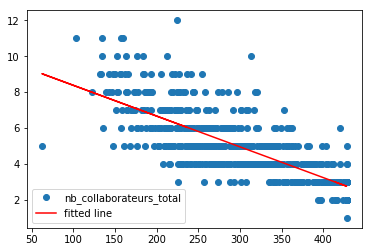

contrat_max : slope:0.153676, intercept:371.135523, 
	rvalue:0.372251, pvalue:0.000000, stderr:0.000000



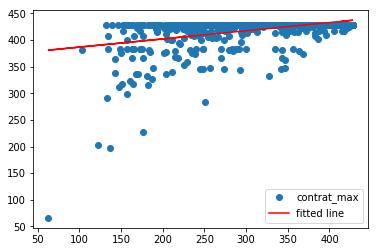

contrat_min : slope:1.424549, intercept:-281.593717, 
	rvalue:0.823888, pvalue:0.000000, stderr:0.000000



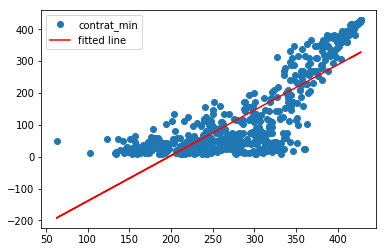

nb_contrats_plus_de_2_mois : slope:-0.010385, intercept:7.598668, 
	rvalue:-0.539271, pvalue:0.000000, stderr:0.000000



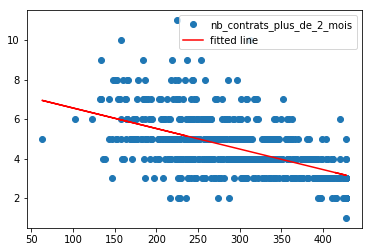

nb_contrats_plus_de_4_mois : slope:-0.006445, intercept:6.098497, 
	rvalue:-0.378217, pvalue:0.000000, stderr:0.000000



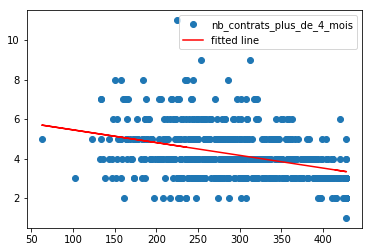

nb_contrats_plus_de_6_mois : slope:-0.004489, intercept:5.334885, 
	rvalue:-0.284946, pvalue:0.000000, stderr:0.000000



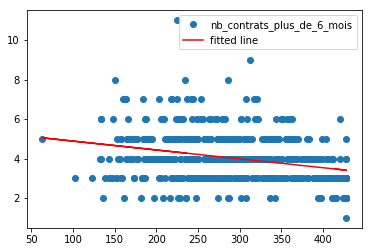

nb_contrat_fini : slope:-0.015367, intercept:6.055177, 
	rvalue:-0.788972, pvalue:0.000000, stderr:0.000000



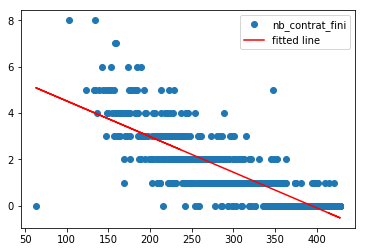

contrat_fini_max : slope:-0.131113, intercept:223.060589, 
	rvalue:-0.097800, pvalue:0.020177, stderr:0.020177



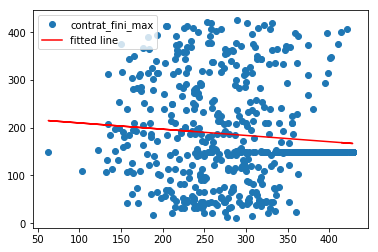

contrat_fini_min : slope:0.570562, intercept:-48.051718, 
	rvalue:0.506665, pvalue:0.000000, stderr:0.000000



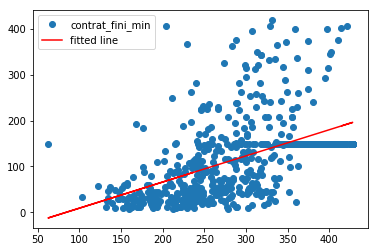

ancien_depute : slope:0.000671, intercept:0.071487, 
	rvalue:0.117231, pvalue:0.005311, stderr:0.005311



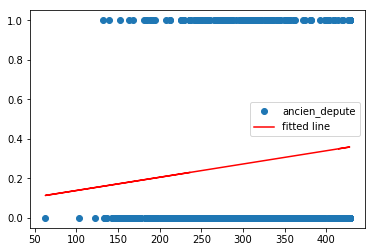

ratio_contrat_mandat : slope:0.002682, intercept:-0.109774, 
	rvalue:0.900595, pvalue:0.000000, stderr:0.000000



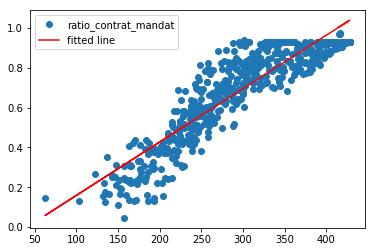

nb_mandats : non significatif

parlementaire_age : slope:0.017622, intercept:44.800237, 
	rvalue:0.122752, pvalue:0.003503, stderr:0.003503



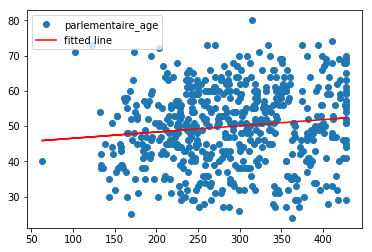

contrat_present_a_date_rotation_un_an : slope:0.002128, intercept:2.213057, 
	rvalue:0.152586, pvalue:0.000276, stderr:0.000276



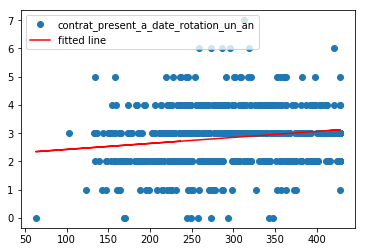

contrat_entree_depuis_date_rotation_un_an : slope:-0.017874, intercept:7.343770, 
	rvalue:-0.819004, pvalue:0.000000, stderr:0.000000



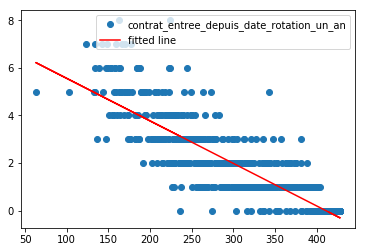

contrat_sortie_depuis_date_rotation_un_an : slope:-0.013987, intercept:5.516653, 
	rvalue:-0.754786, pvalue:0.000000, stderr:0.000000



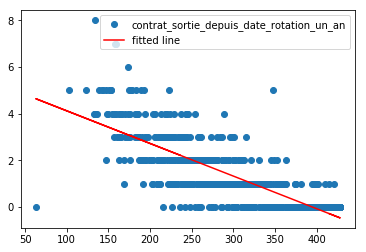

contrat_present_moyen : non significatif

emploi_rotation_un_an : slope:-0.005435, intercept:2.180098, 
	rvalue:-0.808187, pvalue:0.000000, stderr:0.000000



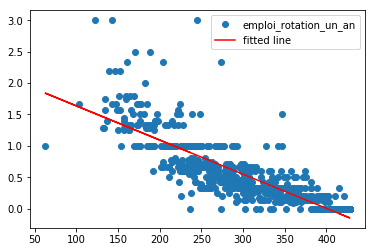

emploi_taux_depart_un_an : slope:-0.004747, intercept:1.858580, 
	rvalue:-0.735466, pvalue:0.000000, stderr:0.000000



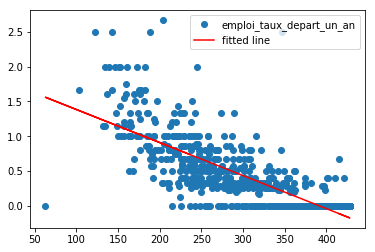

emploi_taux_arrivee_un_an : slope:-0.006122, intercept:2.501616, 
	rvalue:-0.755492, pvalue:0.000000, stderr:0.000000



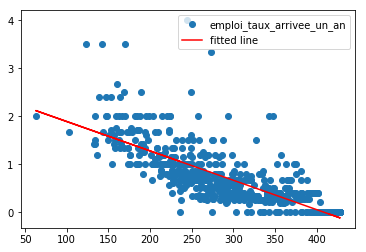

contrat_present_a_date_rotation_six_mois : slope:0.001002, intercept:3.170692, 
	rvalue:0.080985, pvalue:0.054584, stderr:0.054584



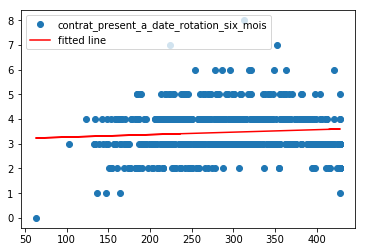

contrat_entree_depuis_date_rotation_six_mois : slope:-0.008950, intercept:3.393625, 
	rvalue:-0.674171, pvalue:0.000000, stderr:0.000000



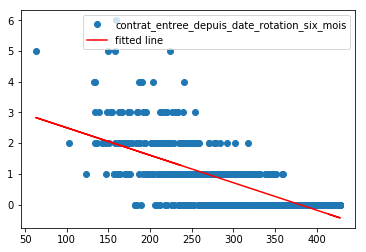

contrat_sortie_depuis_date_rotation_six_mois : slope:-0.006188, intercept:2.524143, 
	rvalue:-0.514106, pvalue:0.000000, stderr:0.000000



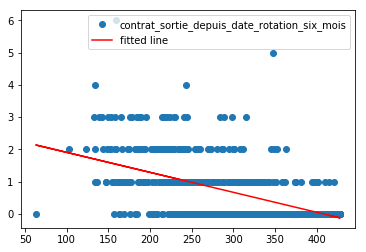

emploi_rotation_six_mois : non significatif

emploi_taux_depart_six_mois : non significatif

emploi_taux_arrivee_six_mois : non significatif

parlementaire_femme : slope:-0.001040, intercept:0.696952, 
	rvalue:-0.164279, pvalue:0.000089, stderr:0.000089



/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


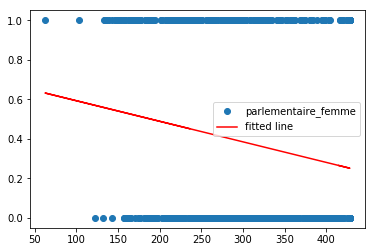

parlementaire_homme : slope:0.001040, intercept:0.303048, 
	rvalue:0.164279, pvalue:0.000089, stderr:0.000089



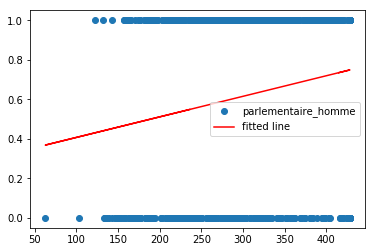

parlementaire_has_autre_mandats : non significatif

groupe_LR : non significatif

groupe_LREM : slope:-0.000771, intercept:0.771196, 
	rvalue:-0.119515, pvalue:0.004480, stderr:0.004480



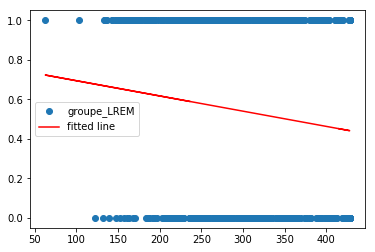

groupe_UAI : non significatif

groupe_NG : non significatif

groupe_MODEM : non significatif

groupe_LFI : non significatif

groupe_NI : non significatif

groupe_GDR : non significatif



In [276]:
tt = {}
for i in duree_tt.columns[4:].drop(["contrat_moyenne", "contrat_mediane", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Tests statistiques sur les collaborateurs

### Préparation des données

In [277]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'nb_mandats', 'parlementaire_age', 'ancien_depute'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs = tous_collaborateurs.drop(['groupe_sigle', 'parti_ratt_financier', 'sites_web','emails', 'adresses', 'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats', 'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug', 'url_nosdeputes', "duree_mandat", "departement"], 1)
#tous_collaborateurs.columns[24:]

### Test de significativité des variables dichotomiques

In [279]:
for i in tous_collaborateurs.columns[24:].drop(["contrat_fini", "contrat_plus_de_2_mois", "nombredejours","contrat_plus_de_4_mois", "contrat_plus_de_6_mois","parlementaire_age","contrat_mediane","contrat_moyenne","nb_collaborateurs_total","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 3.959875, 0.000077

nb_mandats non significatif

groupe_majoritaire : -4.242262, 0.000023

contrat_present_a_date_rotation_un_an_x : 49.652475, 0.000000

contrat_entree_depuis_date_rotation_un_an_x : -40.631140, 0.000000

contrat_sortie_depuis_date_rotation_un_an_x : -30.710566, 0.000000

contrat_present_a_date_rotation_six_mois_x : 93.964270, 0.000000

contrat_entree_depuis_date_rotation_six_mois_x : -37.620194, 0.000000

contrat_sortie_depuis_date_rotation_six_mois_x : -10.151004, 0.000000

contrat_present_a_date_rotation_un_an_y non significatif

contrat_entree_depuis_date_rotation_un_an_y : -7.965056, 0.000000

contrat_sortie_depuis_date_rotation_un_an_y : -9.010077, 0.000000

contrat_present_moyen non significatif

emploi_rotation_un_an : -16.591230, 0.000000

emploi_taux_depart_un_an : -15.652202, 0.000000

emploi_taux_arrivee_un_an : -16.256519, 0.000000

contrat_present_a_date_rotation_six_mois_y : 1.913346, 0.068806

contrat_entree_depuis_date_rotation_six_mois

### Tests de régression sur les variables continues

ancien_depute : slope:0.000217, intercept:0.211393, 
	rvalue:0.073436, pvalue:0.000077, stderr:0.000077



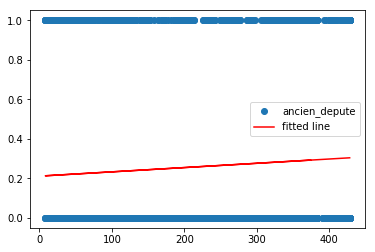

nb_mandats : non significatif

groupe_majoritaire : slope:-0.000252, intercept:0.699699, 
	rvalue:-0.078641, pvalue:0.000023, stderr:0.000023



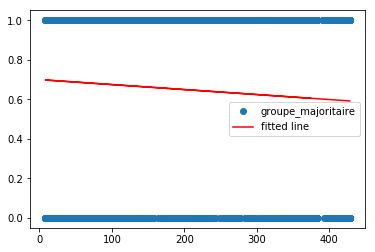

contrat_fini : slope:-0.001752, intercept:0.784844, 
	rvalue:-0.568882, pvalue:0.000000, stderr:0.000000



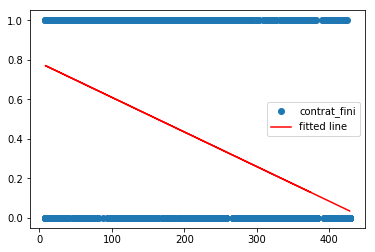

parlementaire_age : slope:0.005236, intercept:48.180593, 
	rvalue:0.072148, pvalue:0.000102, stderr:0.000102



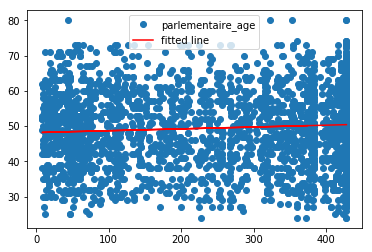

contrat_plus_de_2_mois : slope:0.001085, intercept:0.601427, 
	rvalue:0.530873, pvalue:0.000000, stderr:0.000000



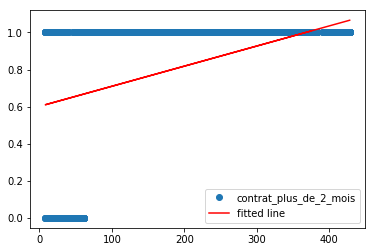

contrat_plus_de_4_mois : slope:0.001630, intercept:0.384370, 
	rvalue:0.644889, pvalue:0.000000, stderr:0.000000



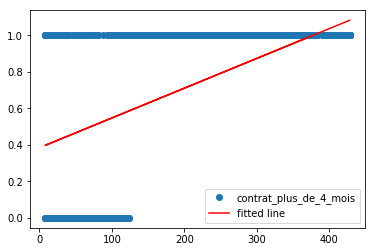

contrat_plus_de_6_mois : slope:0.001828, intercept:0.292721, 
	rvalue:0.670748, pvalue:0.000000, stderr:0.000000



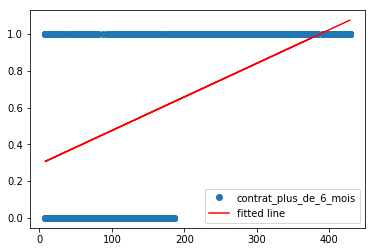

contrat_present_a_date_rotation_un_an_x : slope:0.002242, intercept:-0.053733, 
	rvalue:0.678368, pvalue:0.000000, stderr:0.000000



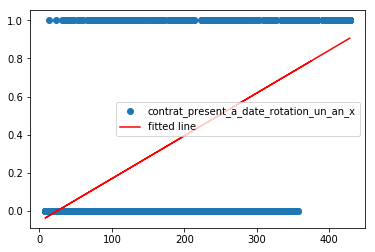

contrat_entree_depuis_date_rotation_un_an_x : slope:-0.001978, intercept:0.955565, 
	rvalue:-0.602827, pvalue:0.000000, stderr:0.000000



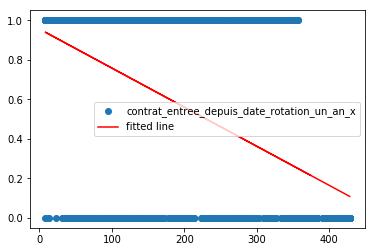

contrat_sortie_depuis_date_rotation_un_an_x : slope:-0.001488, intercept:0.686676, 
	rvalue:-0.495904, pvalue:0.000000, stderr:0.000000



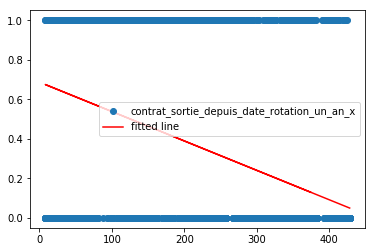

contrat_present_a_date_rotation_six_mois_x : slope:0.002702, intercept:-0.055015, 
	rvalue:0.867911, pvalue:0.000000, stderr:0.000000



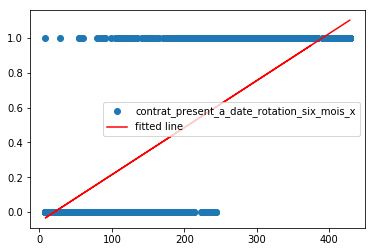

contrat_entree_depuis_date_rotation_six_mois_x : slope:-0.001382, intercept:0.528800, 
	rvalue:-0.573218, pvalue:0.000000, stderr:0.000000



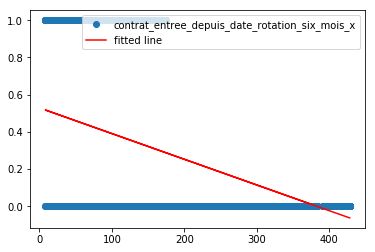

contrat_sortie_depuis_date_rotation_six_mois_x : slope:-0.000431, intercept:0.258629, 
	rvalue:-0.185484, pvalue:0.000000, stderr:0.000000



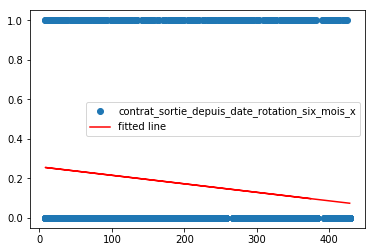

nb_collaborateurs_total : slope:-0.004662, intercept:7.031241, 
	rvalue:-0.358697, pvalue:0.000000, stderr:0.000000



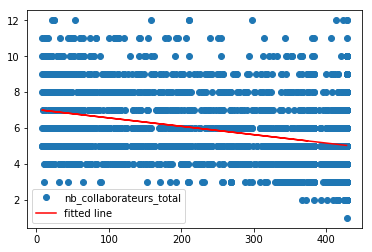

contrat_max : slope:0.042634, intercept:402.656190, 
	rvalue:0.190837, pvalue:0.000000, stderr:0.000000



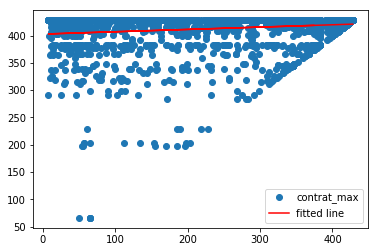

contrat_min : slope:0.301742, intercept:20.263841, 
	rvalue:0.392612, pvalue:0.000000, stderr:0.000000



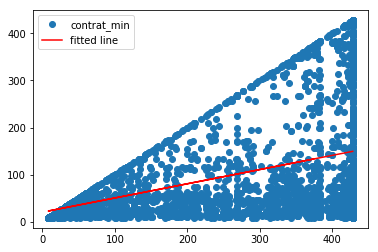

nb_contrats_plus_de_2_mois : slope:-0.002616, intercept:5.758734, 
	rvalue:-0.247501, pvalue:0.000000, stderr:0.000000



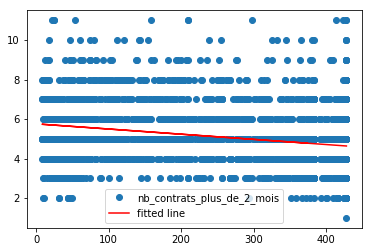

nb_contrats_plus_de_4_mois : slope:-0.001459, intercept:4.988970, 
	rvalue:-0.155293, pvalue:0.000000, stderr:0.000000



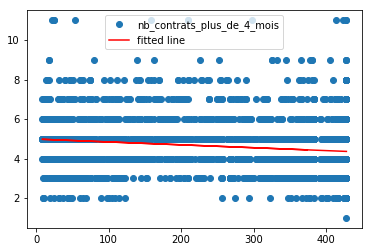

nb_contrats_plus_de_6_mois : slope:-0.000899, intercept:4.581702, 
	rvalue:-0.103309, pvalue:0.000000, stderr:0.000000



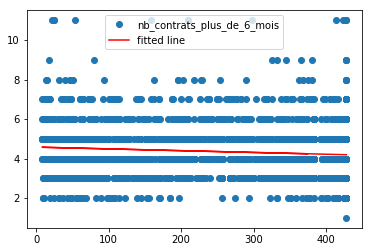

nb_contrat_fini : slope:-0.004423, intercept:3.229265, 
	rvalue:-0.399328, pvalue:0.000000, stderr:0.000000



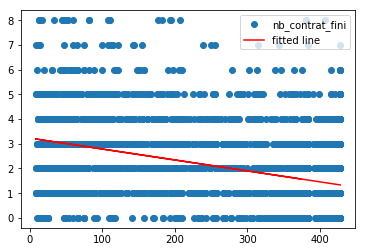

ratio_contrat_fini : slope:-0.000514, intercept:0.450806, 
	rvalue:-0.383295, pvalue:0.000000, stderr:0.000000



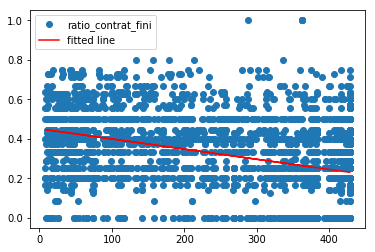

contrat_fini_max : slope:-0.036109, intercept:202.425991, 
	rvalue:-0.050549, pvalue:0.006531, stderr:0.006531



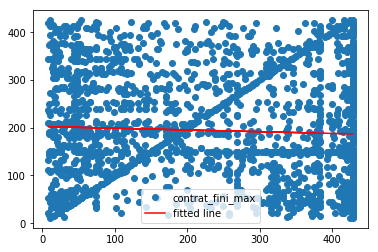

contrat_fini_min : slope:0.152889, intercept:62.983818, 
	rvalue:0.268489, pvalue:0.000000, stderr:0.000000



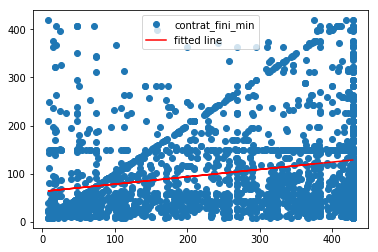

ratio_contrat_mandat : slope:0.000737, intercept:0.412959, 
	rvalue:0.458035, pvalue:0.000000, stderr:0.000000



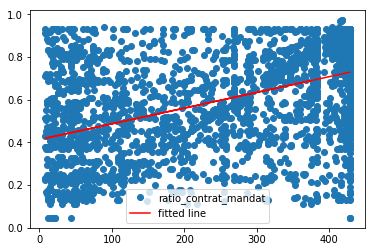

contrat_present_a_date_rotation_un_an_y : slope:0.000756, intercept:2.753036, 
	rvalue:0.099817, pvalue:0.000000, stderr:0.000000



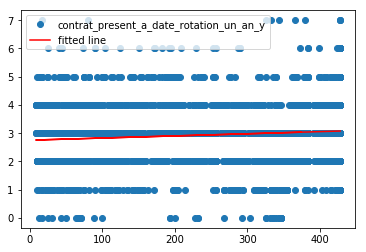

contrat_entree_depuis_date_rotation_un_an_y : slope:-0.005002, intercept:3.989648, 
	rvalue:-0.412385, pvalue:0.000000, stderr:0.000000



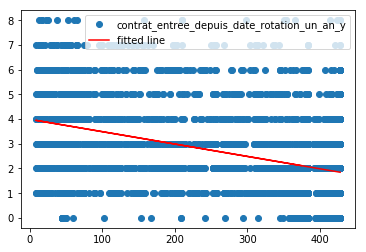

contrat_sortie_depuis_date_rotation_un_an_y : slope:-0.004007, intercept:2.940707, 
	rvalue:-0.382543, pvalue:0.000000, stderr:0.000000



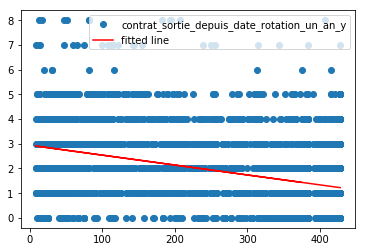

contrat_present_moyen : slope:0.000258, intercept:3.277506, 
	rvalue:0.041656, pvalue:0.025031, stderr:0.025031



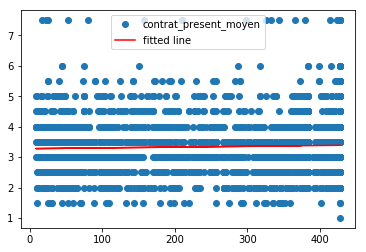

emploi_rotation_un_an : slope:-0.001497, intercept:1.123079, 
	rvalue:-0.406756, pvalue:0.000000, stderr:0.000000



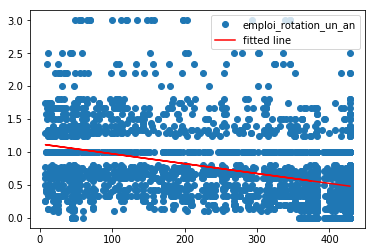

emploi_taux_depart_un_an : slope:-0.001329, intercept:0.948643, 
	rvalue:-0.374325, pvalue:0.000000, stderr:0.000000



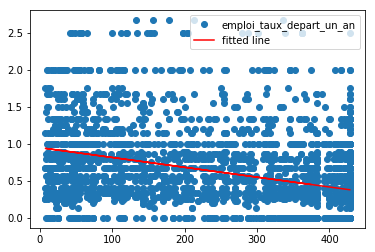

emploi_taux_arrivee_un_an : slope:-0.001666, intercept:1.297515, 
	rvalue:-0.382288, pvalue:0.000000, stderr:0.000000



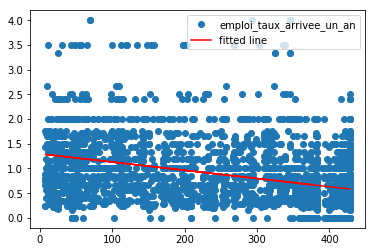

contrat_present_a_date_rotation_six_mois_y : slope:0.000556, intercept:3.468350, 
	rvalue:0.083016, pvalue:0.000008, stderr:0.000008



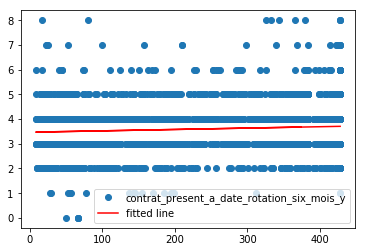

contrat_entree_depuis_date_rotation_six_mois_y : slope:-0.002568, intercept:1.730798, 
	rvalue:-0.334527, pvalue:0.000000, stderr:0.000000



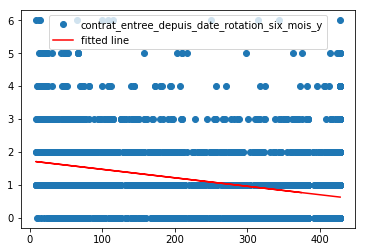

contrat_sortie_depuis_date_rotation_six_mois_y : slope:-0.001772, intercept:1.397172, 
	rvalue:-0.260966, pvalue:0.000000, stderr:0.000000



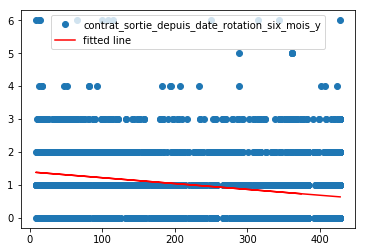

emploi_rotation_six_mois : non significatif

emploi_taux_depart_six_mois : non significatif

emploi_taux_arrivee_six_mois : non significatif

parlementaire_femme : slope:-0.000345, intercept:0.501964, 
	rvalue:-0.105668, pvalue:0.000000, stderr:0.000000



/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


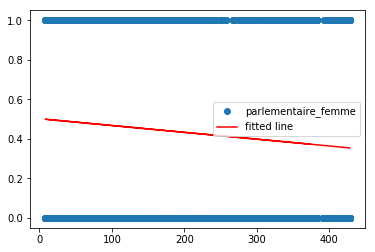

parlementaire_homme : slope:0.000345, intercept:0.498036, 
	rvalue:0.105668, pvalue:0.000000, stderr:0.000000



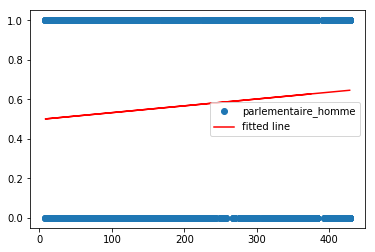

parlementaire_has_autre_mandats : non significatif

groupe_LR : slope:0.000141, intercept:0.139538, 
	rvalue:0.055530, pvalue:0.002805, stderr:0.002805



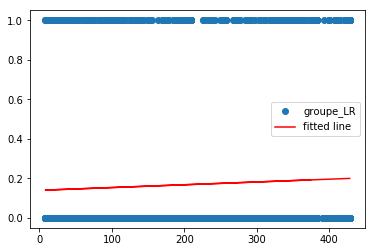

groupe_LREM : slope:-0.000258, intercept:0.625255, 
	rvalue:-0.078107, pvalue:0.000026, stderr:0.000026



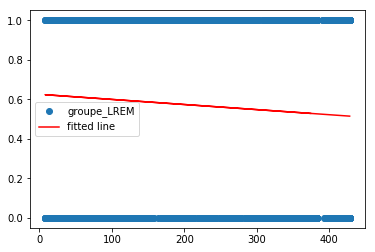

groupe_UAI : non significatif

groupe_NG : slope:0.000045, intercept:0.033243, 
	rvalue:0.032239, pvalue:0.082914, stderr:0.082914



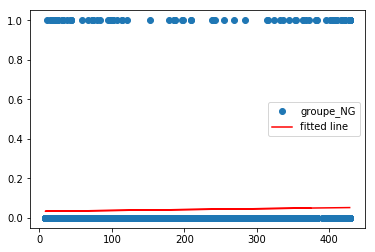

groupe_MODEM : non significatif

groupe_LFI : slope:0.000043, intercept:0.017289, 
	rvalue:0.038973, pvalue:0.036041, stderr:0.036041



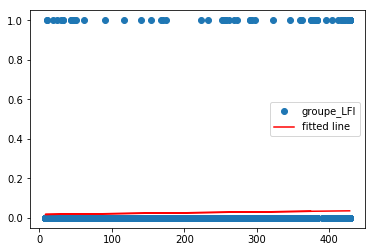

groupe_NI : non significatif

groupe_GDR : non significatif

collaborateur_femme : slope:0.000164, intercept:0.452659, 
	rvalue:0.049315, pvalue:0.007969, stderr:0.007969



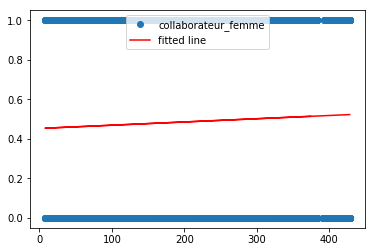

collaborateur_homme : slope:-0.000164, intercept:0.547341, 
	rvalue:-0.049315, pvalue:0.007969, stderr:0.007969



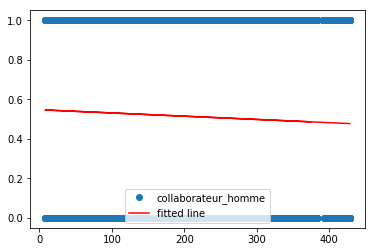

In [280]:
tt = {}
for i in tous_collaborateurs.drop(["nombredejours", "contrat_moyenne", "contrat_mediane", "ratio_plus_de_2_mois","ratio_plus_de_4_mois","ratio_plus_de_6_mois"], 1).columns[24:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Conclusions

On observe une rotation du travail moyenne à l'échelle de l'Assemblée comparable au taux moyen français pour les entreprises de petite taille. Malgré cela, certains parlementaires ont un taux sensiblement au-dessus de la moyenne.

Nous avons isolé des parlementaires dont le taux de rotation de l'emploi est le plus haut grâce à des critères descriptifs simples basés sur les temps de contrats des collaborateurs et leur nombre de collaborateurs.

Une série de tests statistiques nous a permis de mesurer l'effet de différentes caractéristiques des parlementaires (sexe, âge, groupe politique, etc...) sur la durée médiane des contrats de leurs collaborateurs.

Des profils de managers et d'employés émergent de notre analyse des données collectées depuis le 22 juin 2017. La présence de collaborateurs fidèles, l'influence du sexe, de l'âge ou de l'ancienneté du parlementaire sur la durée des collaborations, ou encore la propension des groupes LREM et NI a se séparer plus rapidement de leur collaborateurs méritent d'être étudiés plus en détails. Notamment à la lumière d'informations complémentaires sur la teneur des contrats des collaborateurs parlementaires.